In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
def smoothing(data):
    series = data
    # Tail-rolling average transform
    rolling = series.rolling(window=6)
    rolling_mean = rolling.mean()
    return rolling_mean
    

In [49]:
#Extract Data
data = pd.read_csv("~/Desktop/NCSA_genomics/Python - notebooks/TSForecasting/Data/Hall/data_hall_raw.csv")
df = data[data['subjectId']=='1636-69-032']
df = df.reset_index(drop=True)
df['GlucoseValue'] = smoothing(df['GlucoseValue'])
df = df[df['GlucoseValue'].notna()]
df=df.reset_index(drop=True)
df


Display Time  GlucoseValue    subjectId
0     2016-01-13 13:23:17    127.833333  1636-69-032
1     2016-01-13 13:28:17    129.500000  1636-69-032
2     2016-01-13 13:33:17    130.833333  1636-69-032
3     2016-01-13 13:38:17    131.166667  1636-69-032
4     2016-01-13 13:43:17    130.166667  1636-69-032
...                   ...           ...          ...
1773  2016-01-19 17:12:49     99.166667  1636-69-032
1774  2016-01-19 17:17:49     97.833333  1636-69-032
1775  2016-01-19 17:22:49     98.666667  1636-69-032
1776  2016-01-19 17:27:49    101.000000  1636-69-032
1777  2016-01-19 17:32:49    101.833333  1636-69-032

[1778 rows x 3 columns]

In [51]:
from TSForecasting.mage_calc import MageDataSet
glucs = df['GlucoseValue'].to_list()
indices = [1*i for i in range(len(glucs))]
m = MageDataSet(indices, glucs)
k = m.getMAGE()
k





31.230994152046772

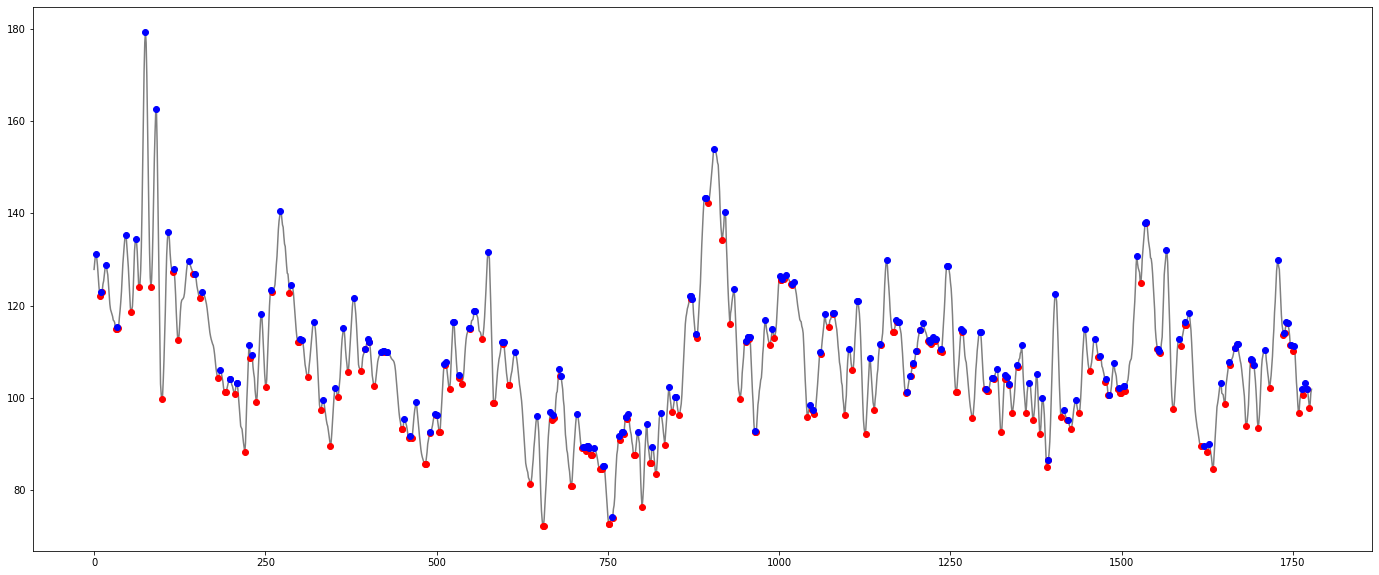

In [56]:
# example data with peaks:
x = indices
gvs = glucs

#     ___ detection of local minimums and maximums ___

a = np.diff(np.sign(np.diff(gvs))).nonzero()[0] + 1               # local min & max
valleys = (np.diff(np.sign(np.diff(gvs))) > 0).nonzero()[0] + 1         # local min
peaks = (np.diff(np.sign(np.diff(gvs))) < 0).nonzero()[0] + 1         # local max
# +1 due to the fact that diff reduces the original index number
# print(len(valleys))
# print(len(peaks))

# plot
plt.figure(figsize=(24, 10))
plt.plot(x, gvs, color='grey')
for i in valleys:
    plt.plot(x[i], gvs[i], "o", label="min", color='r')
for i in peaks:
    plt.plot(x[i], gvs[i], "o", label="max", color='b')
plt.show()

In [57]:
print(len(peaks),len(valleys))



195 198


In [58]:
data2 = pd.DataFrame(columns=['Index', 'Timestamp', 'GlucoseValue', 'Type'])
k=0
for i in range(len(peaks)):
    data2.loc[k] = [peaks[i]] + [df['Display Time'][k]] + [df['GlucoseValue'][k]] + ["P"]
    k+=1

for i in range(len(valleys)):
    data2.loc[k] = [valleys[i]] + [df['Display Time'][k]] + [df['GlucoseValue'][k]] + ["V"]
    k+=1

data2 = data2.sort_values(by=['Index'])
data2=data2.reset_index(drop=True)
data2

Index            Timestamp  GlucoseValue Type
0       3  2016-01-13 13:23:17    127.833333    P
1       9  2016-01-14 05:38:14    102.666667    V
2      10  2016-01-13 13:28:17    129.500000    P
3      11  2016-01-14 05:43:14    103.333333    V
4      17  2016-01-13 13:33:17    130.833333    P
..    ...                  ...           ...  ...
388  1765  2016-01-14 21:53:11    106.000000    V
389  1768  2016-01-14 05:28:14    101.666667    P
390  1770  2016-01-14 21:58:11    106.833333    V
391  1771  2016-01-14 05:33:14    102.000000    P
392  1774  2016-01-14 22:03:11    108.666667    V

[393 rows x 4 columns]

In [59]:
stdev = 5
data3 = pd.DataFrame(columns=['Index', 'Timestamp', 'GlucoseValue', 'Type'])
k=0
for i in range(stdev,len(data2.Index)-stdev):
    indices = [i-stdev,i,i+stdev]
    for j in range(0,len(indices)-1):
        if(data2.Type[indices[j]] == data2.Type[indices[j+1]]):
            #print(data2["Type"][indices[j]],data2["Type"][indices[j+1]])
            if(data2.Type[indices[j]]=='P'):
                if data2.GlucoseValue[indices[j]]>=data2.GlucoseValue[indices[j+1]]:
                    #data3 = pd.concat([data3,data2.loc[indices[j+1]]],ignore_index=True)
                    data3.loc[k] = data2.loc[indices[j+1]]
                    k+=1
                else:
                    #data3 = pd.concat([data3,data2.loc[indices[j]]],ignore_index=True)
                    data3.loc[k] = data2.loc[indices[j]]
                    k+=1
            else:
                if data2.GlucoseValue[indices[j]]<=data2.GlucoseValue[indices[j+1]]:
                    #data3 = pd.concat([data3,data2.loc[indices[j+1]]],ignore_index=True)
                    data3.loc[k] = data2.loc[indices[j+1]]
                    k+=1
                else:
                    #data3 = pd.concat([data3,data2.loc[indices[j]]],ignore_index=True)
                    data3.loc[k] = data2.loc[indices[j]]
                    k+=1
                
data3

Index            Timestamp  GlucoseValue Type
0      32  2016-01-14 05:48:14    103.833333    V
1      33  2016-01-14 05:53:14    104.166667    V
2      10  2016-01-13 13:28:17    129.500000    P
3      35  2016-01-14 05:58:14    104.166667    V
4      46  2016-01-13 13:43:17    130.166667    P
..    ...                  ...           ...  ...
293  1669  2016-01-14 04:28:14    104.333333    P
294  1682  2016-01-14 20:58:11    121.666667    V
295  1688  2016-01-14 04:33:14    104.500000    P
296  1689  2016-01-14 21:03:11    121.333333    V
297  1668  2016-01-14 04:23:15    104.500000    P

[298 rows x 4 columns]

In [60]:
data3 = data3.drop_duplicates(subset= "Index", keep= "first")

In [61]:
data3

Index            Timestamp  GlucoseValue Type
0      32  2016-01-14 05:48:14    103.833333    V
1      33  2016-01-14 05:53:14    104.166667    V
2      10  2016-01-13 13:28:17    129.500000    P
3      35  2016-01-14 05:58:14    104.166667    V
4      46  2016-01-13 13:43:17    130.166667    P
..    ...                  ...           ...  ...
288  1669  2016-01-14 04:28:14    104.333333    P
289  1682  2016-01-14 20:58:11    121.666667    V
290  1688  2016-01-14 04:33:14    104.500000    P
291  1689  2016-01-14 21:03:11    121.333333    V
292  1668  2016-01-14 04:23:15    104.500000    P

[145 rows x 4 columns]

In [62]:
for i in data3.Index:
    for j in data2.Index:
        if j == i:
            data2 = data2[data2["Index"]!=j]


data2

Index            Timestamp  GlucoseValue Type
0       3  2016-01-13 13:23:17    127.833333    P
1       9  2016-01-14 05:38:14    102.666667    V
3      11  2016-01-14 05:43:14    103.333333    V
4      17  2016-01-13 13:33:17    130.833333    P
7      34  2016-01-13 13:38:17    131.166667    P
..    ...                  ...           ...  ...
388  1765  2016-01-14 21:53:11    106.000000    V
389  1768  2016-01-14 05:28:14    101.666667    P
390  1770  2016-01-14 21:58:11    106.833333    V
391  1771  2016-01-14 05:33:14    102.000000    P
392  1774  2016-01-14 22:03:11    108.666667    V

[248 rows x 4 columns]

In [63]:
print(data2.GlucoseValue.sum()/len(data2.Index))

115.96841397849462


In [43]:
type(data2.Timestamp)

pandas.core.series.Series